In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

In [3]:
def get_experiment_directory_str(base_name : str, maxk : int, benchmark : str, spec : str, stochastic : bool = True):
    return f"{base_name}/train_{'stochastic' if stochastic else 'deterministic'}/maxk={maxk}/{benchmark}-{spec}"

In [4]:
def get_traces(base_exp_name, metric = "robust_value", num_runs = 30):
    traces = []
    for i in range(num_runs):
        if metric.lower() == "static_values":
            with open(f"{base_exp_name}/0/{i}/{metric}.txt", 'r') as input:
                trace = np.array([np.array([float(x) for x in line.rstrip()[1:][:-1].split(" ") if x != ""], dtype=float) for line in input if line != ""], dtype=float)
        else:
            with open(f"{base_exp_name}/0/{i}/{metric}.txt", 'r') as input:
                trace = np.array([float(line.rstrip()) for line in input], dtype=float)
        traces.append(trace)
    return np.array(traces)

In [5]:
base_exp_name = "/workspaces/uPOMDP/data/output/SECOND-RUN-2023/08/12-11:45:53637629"
intercept_maxk9_minmax = get_experiment_directory_str(base_exp_name, 9, 'intercept', "Rminmax")

In [16]:
def rnn_empir_plot(basename, maxk, name):
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = get_traces(get_experiment_directory_str(basename, maxk, name, run), metric="rnn_empirical_result")
        # plt.plot(range(100), np.transpose(results))
        plt.plot(range(100), results.mean(axis=0), label=run)
        plt.fill_between(range(100), results.mean(axis=0) + results.std(axis=0), results.mean(axis=0) - results.std(axis=0), alpha=0.75)
        plt.title(f"{name}, $k\leq {maxk}$")
        plt.ylabel("RNN empirical result")
        plt.xlabel("Iteration")
    plt.legend()
    plt.show()

In [17]:
results = np.reshape(get_traces(get_experiment_directory_str("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5", "Rminmax"), metric="static_values"), (30, 4, 100))

In [18]:
def static_evals_subplots(basepath, maxk, name):
    plt.figure(figsize=(12,9))
    plt.suptitle("SC-Maze-5, $k\leq {maxk}$")
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = np.reshape(get_traces(get_experiment_directory_str(basepath, maxk, name, run), metric="static_values"), (30, 4, 100))
        values = [0.1, 0.2, 0.3, 0.4]
        for i in range(4):
            plt.subplot(2, 2, i+1)
            # plt.plot(range(100), np.transpose(results[:, i, :]), label=run)
            plt.plot(range(100), np.mean(results[:, i, :], axis=0), label=run)
            # plt.fill_between(range(100), results[:, i, :].mean(axis=0) + results[:, i, :].std(axis=0), results[:, i, :].mean(axis=0) - results[:, i, :].std(axis=0), alpha=0.75)
            plt.title(f"sl = {values[i]}")
            plt.ylabel("Value")
            # plt.yscale("log")
            plt.xlabel("Iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
def max_static_value_plot(basepath, maxk, name):
    plt.figure(figsize=(12,9))
    plt.title(f"{name}, $k\leq {maxk}$")
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = np.reshape(get_traces(get_experiment_directory_str(basepath, maxk, name, run), metric="static_values"), (30, 4, 100))
        plt.plot(range(100), np.mean(np.max(results, axis=1), axis=0), label=run)
        # plt.fill_between(range(100), results[:, i, :].mean(axis=0) + results[:, i, :].std(axis=0), results[:, i, :].mean(axis=0) - results[:, i, :].std(axis=0), alpha=0.75)
    plt.ylabel("Value")
    plt.xlabel("Iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
benchmarks = ["SC-maze5", "intercept", "evade", "avoid"]

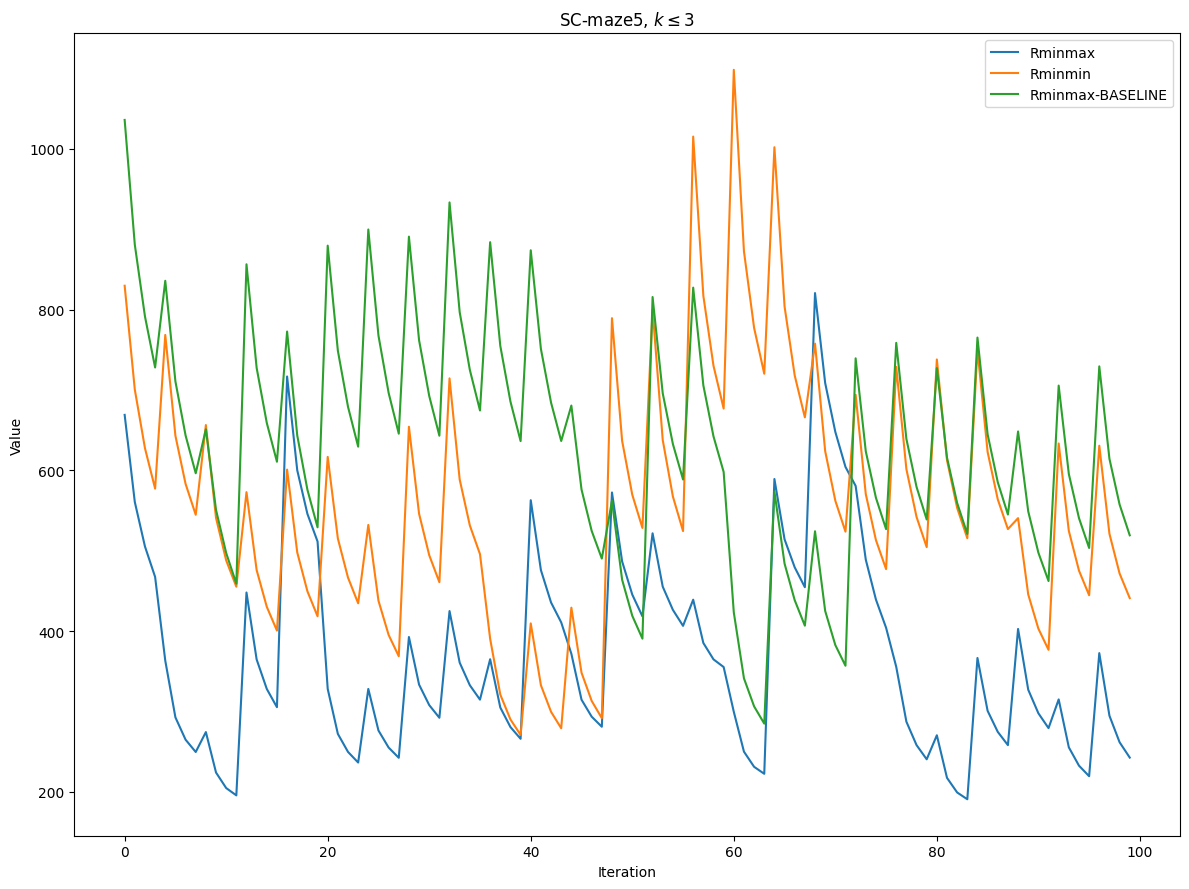

In [27]:
max_static_value_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5")

In [28]:
def make_robust_plot(basepath, maxk, name):
    for run in ["Rminmax", "Rminmin", "Rminmax-BASELINE"]:
        results = get_traces(get_experiment_directory_str(basepath, maxk, name, run), metric="robust_value")
        # plt.plot(range(100), np.transpose(results))
        plt.plot(range(100), results.mean(axis=0), label=run)
        # plt.fill_between(range(100), results.mean(axis=0) + results.std(axis=0), results.mean(axis=0) - results.std(axis=0), alpha=0.75)
        plt.title(f"{name}, $k\leq {maxk}$")
        plt.ylabel("Robust value")
        plt.xlabel("Iteration")
    plt.legend()
    plt.show()

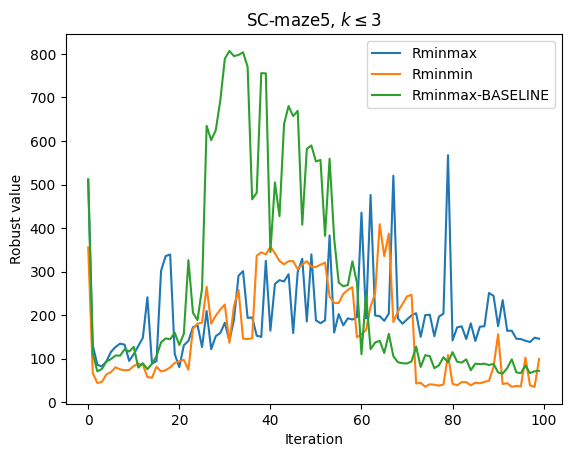

In [29]:
make_robust_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, "SC-maze5")

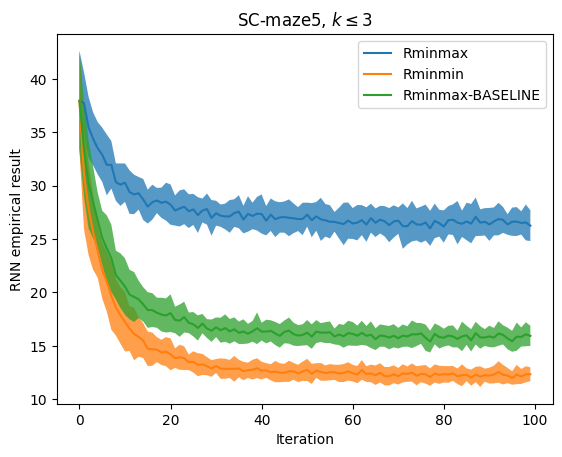

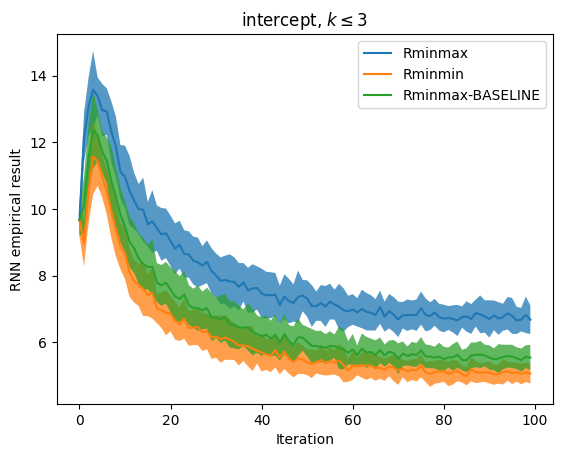

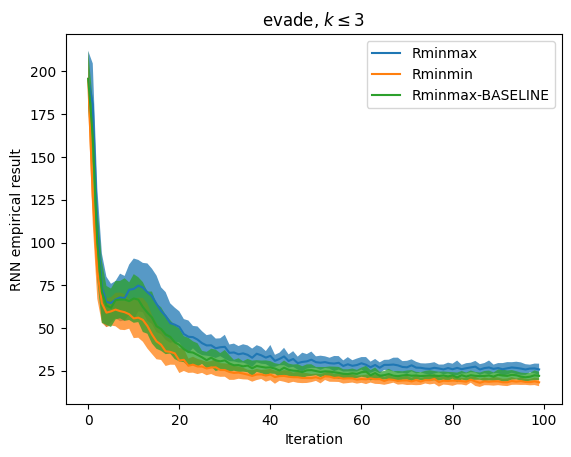

/tmp/ipykernel_174734/2755108051.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(traces)


ValueError: operands could not be broadcast together with shapes (4,) (5,) 

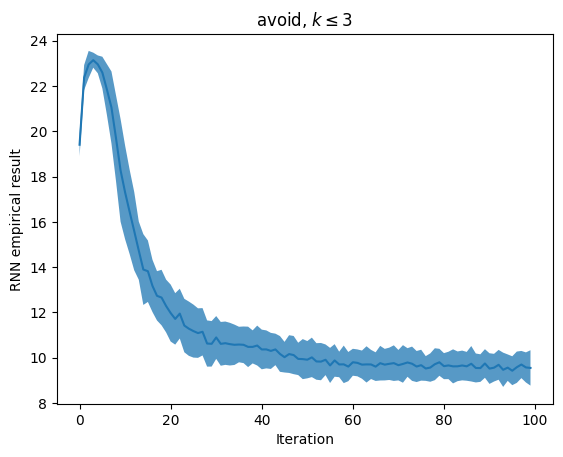

In [30]:
for benchmark in benchmarks:
    rnn_empir_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, benchmark)

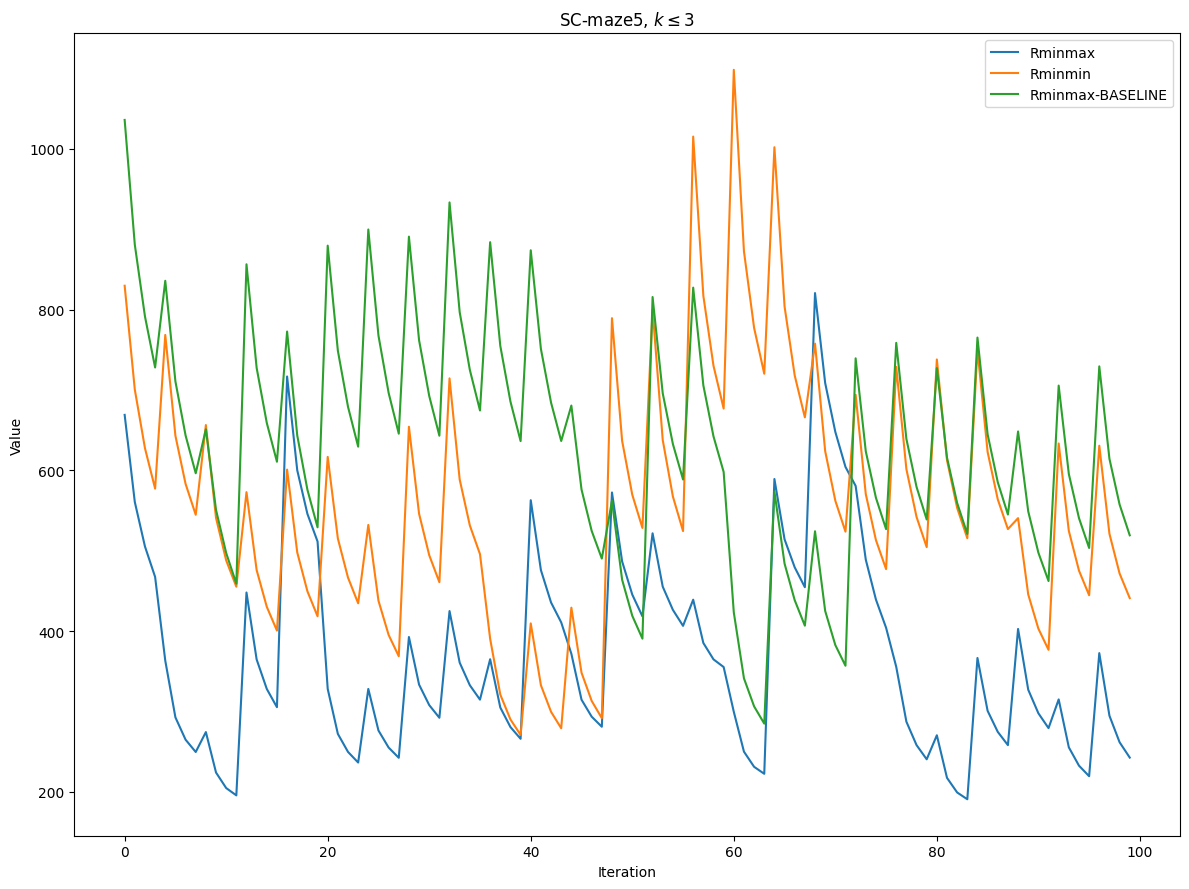

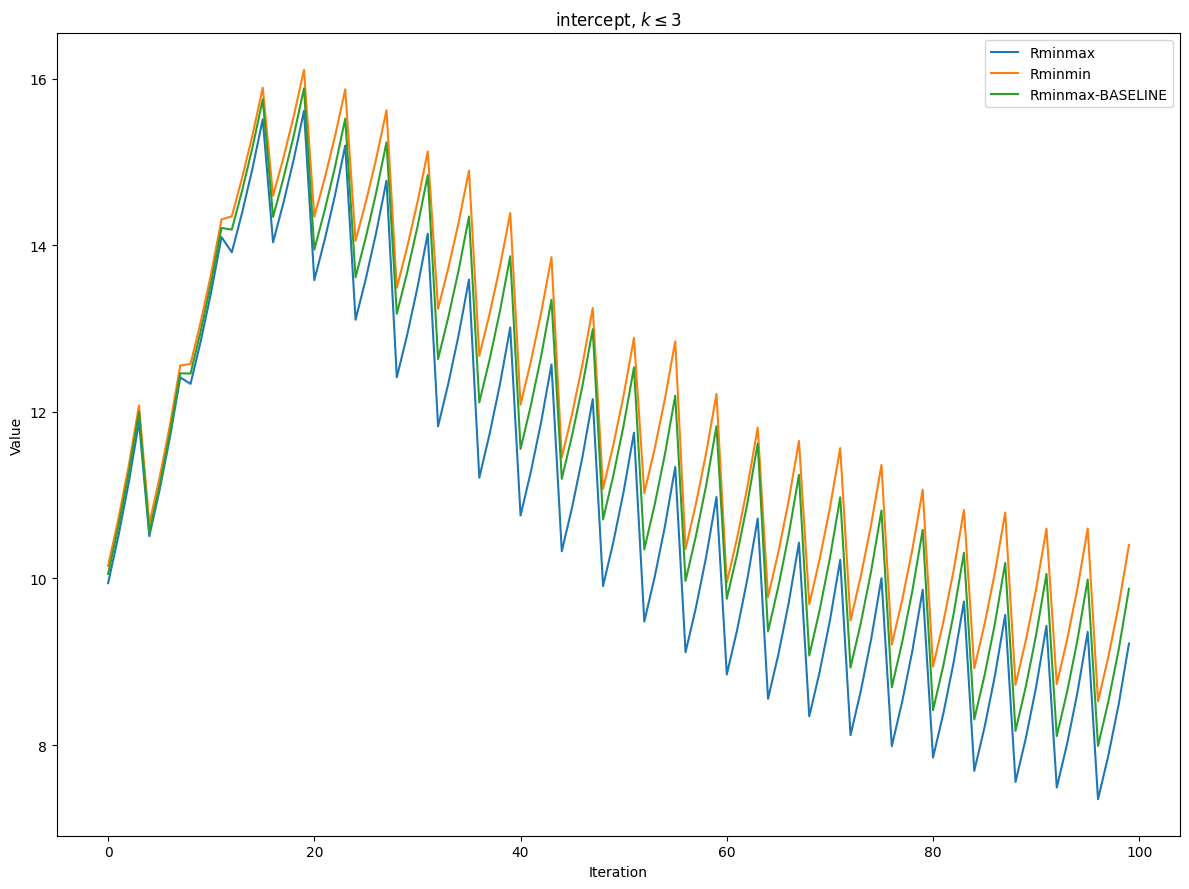

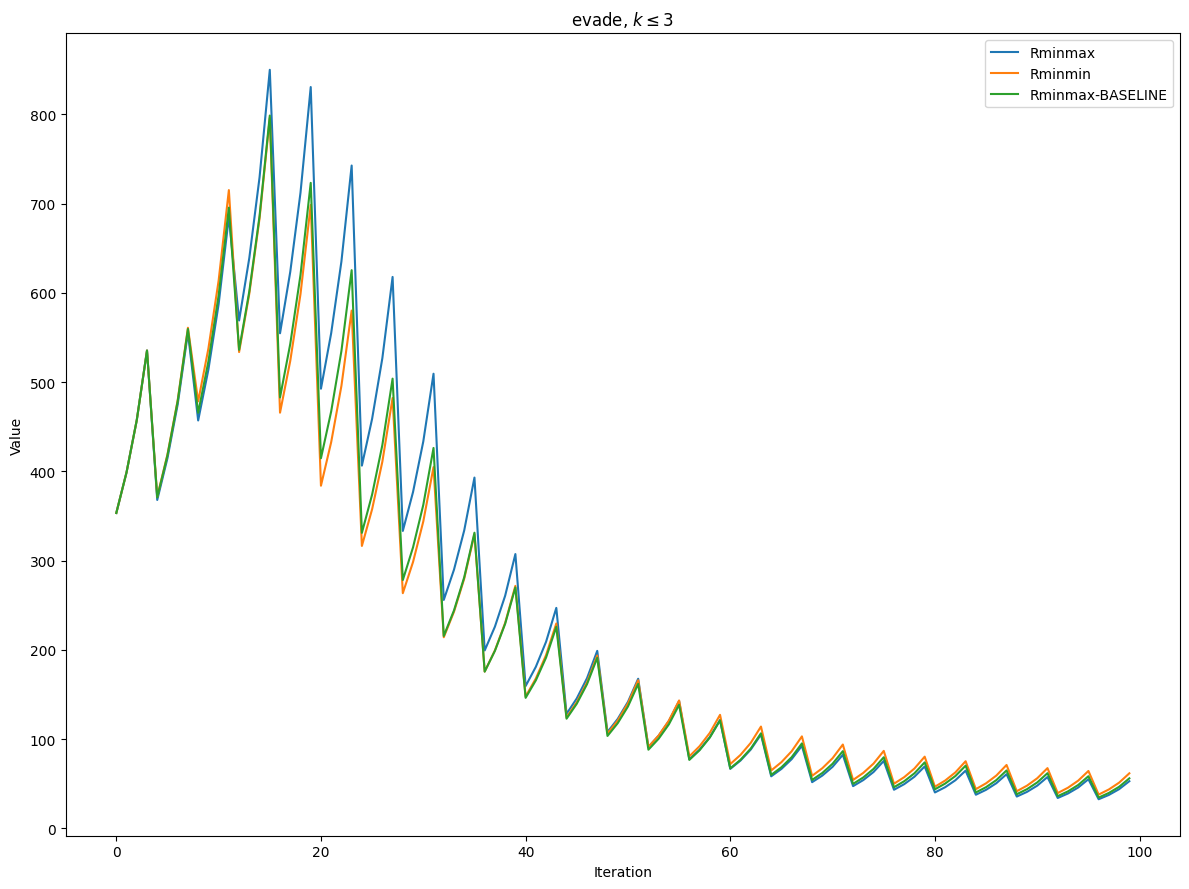

/tmp/ipykernel_174734/2755108051.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(traces)


ValueError: cannot reshape array of size 30 into shape (30,4,100)

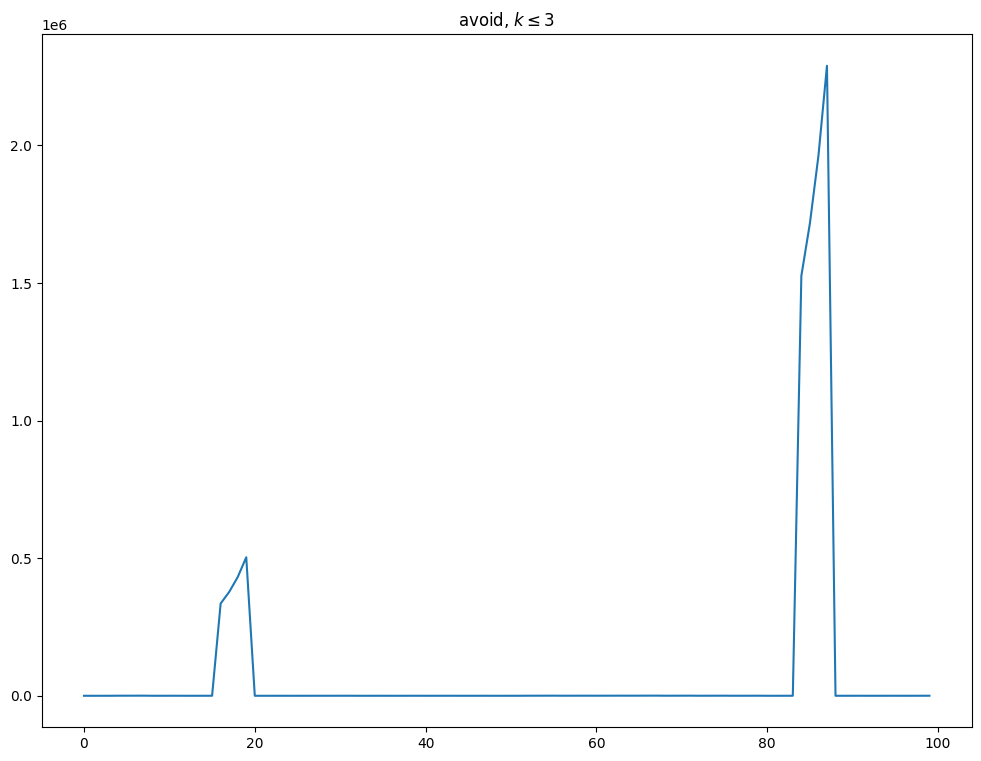

In [31]:
for benchmark in benchmarks:
    max_static_value_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, benchmark)

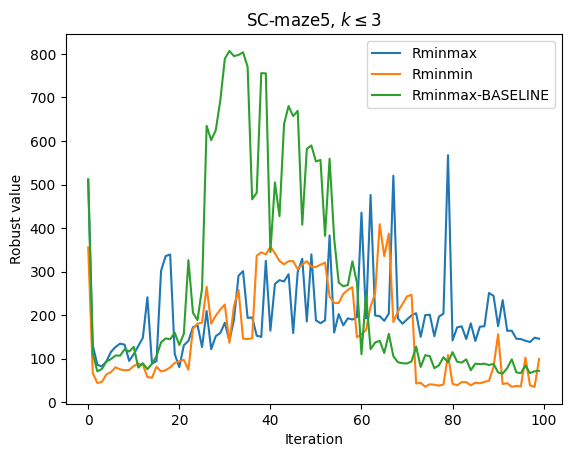

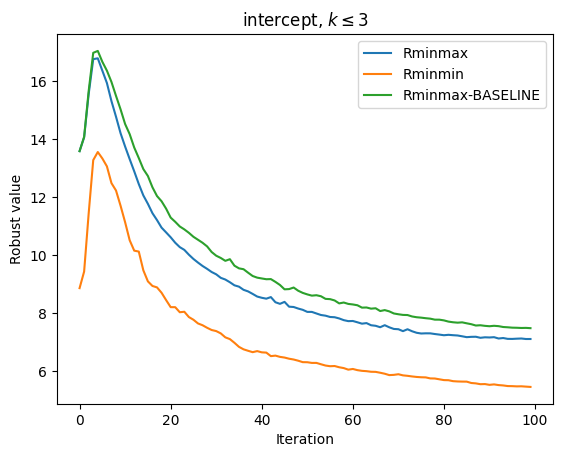

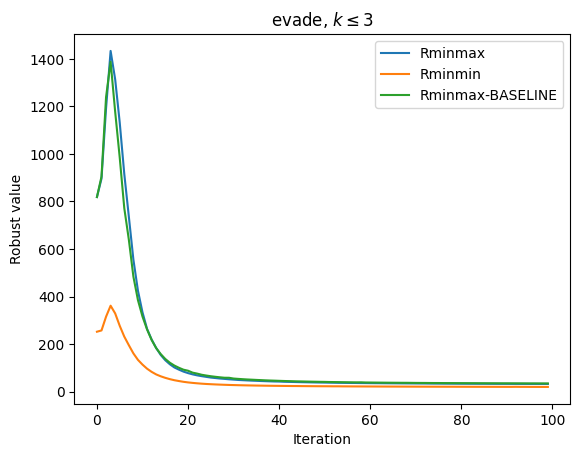

/tmp/ipykernel_174734/2755108051.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(traces)


ValueError: operands could not be broadcast together with shapes (9,) (10,) 

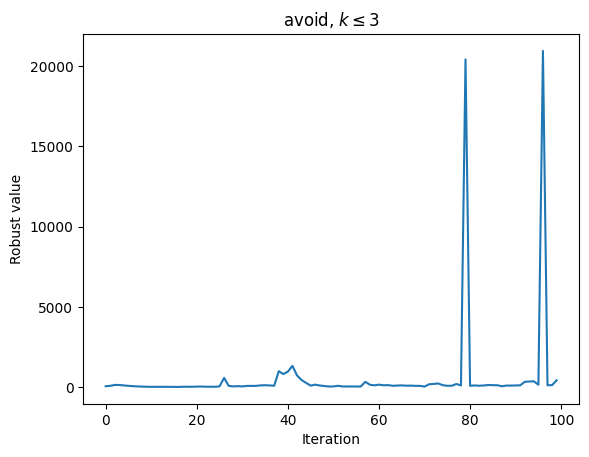

In [32]:
for benchmark in benchmarks:
    make_robust_plot("./data/output/AAAI-RUN-14-08-2023_16h", 3, benchmark)